# Experimento 1

Trabajar con una resta de 2 imagenes simuladas con SkyMaker
-----------------------------------------------------------

Graficos a generar: 
* Imagenes material de resta (componentes S)
* Ver sus transformadas de Fourier
* Ver la transformada acumulada ($\hat{S_d}$)
* Ver el resultado ($S_d$)
* Ver la varianza $\sigma^2(\hat{S_d})$



In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

from properimage import propercoadd as pc
from properimage import propersubtract as ps
from properimage import utils
import stuffskywrapper as w

%matplotlib inline

In [2]:
font = {'family'        : 'sans-serif',
        'sans-serif'    : ['Computer Modern Sans serif'],
        'weight'        : 'regular',
        'size'          : 12}

text = {'usetex'        : True}

plt.rc('font', **font)
plt.rc('text', **text)

In [3]:
stuffconf = {'cat_name' : 'cat.list',
             'im_w'     : 1024,
             'im_h'     : 1024,
             'px_scale' : 0.3
             }

w.write_stuffconf('conf.stuff', stuffconf)
cat_name = w.run_stuff('conf.stuff')

skyconf = {'image_name' : 'test.fits',
           'image_size' : 1024,
           'exp_time'   : 300,
           'mag_zp'     : 25.0,
           'px_scale'   : 0.3,
           'seeing_fwhm': 0.9
           }

w.write_skyconf('conf.sky', skyconf)
img = w.run_sky('conf.sky', img_path='test_image')

In [4]:
ref = w.run_sky('conf.sky', img_path='./testdiff_images/reference.fits', t_exp=400)
new = w.run_sky('conf.sky', img_path='./testdiff_images/newimage.fits', t_exp=400)

In [5]:
subtractor = ps.ImageSubtractor(ref, new)

(1024, 1024)


In [6]:
%time D, D_hat = subtractor.subtract()

background subtracted image obtained
background subtracted image obtained
raw sources = 28
Sources good to calculate = 14
returning best sources
Fitshape = (13, 13)
returning Covariance Matrix
obtainig KL basis, using k = 1
returning variable psf
returning variable psf
getting normal image
starting matched filter
matched filter succesful
getting s component
background subtracted image obtained
background subtracted image obtained
raw sources = 27
Sources good to calculate = 13
returning best sources
Fitshape = (13, 13)
returning Covariance Matrix
obtainig KL basis, using k = 1
returning variable psf
returning variable psf
getting normal image
starting matched filter
matched filter succesful
getting s component
2.0044695061
CPU times: user 2.24 s, sys: 332 ms, total: 2.57 s
Wall time: 2.25 s


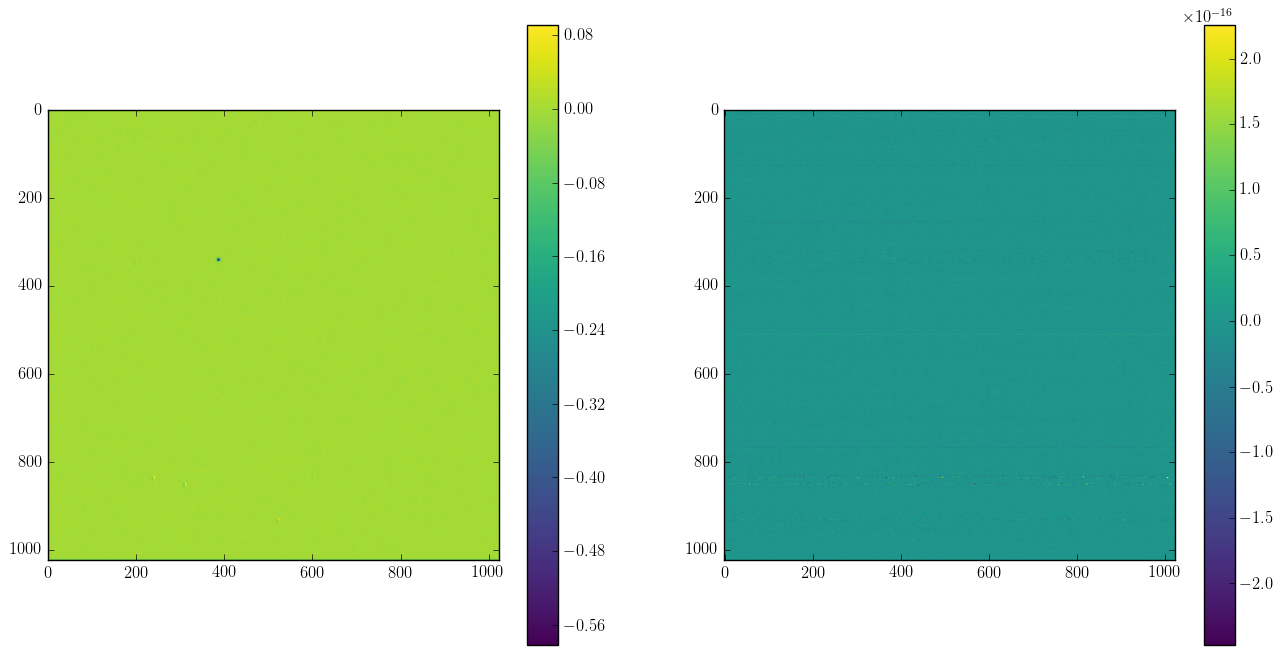

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(D.real, interpolation='none', cmap='viridis')
plt.colorbar()
plt.subplot(122)
plt.imshow(D.imag, interpolation='none', cmap='viridis')
plt.colorbar()

(array([  4.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          6.00000000e+00,   1.50000000e+01,   2.60200000e+03,
          2.61400000e+03,   2.65400000e+03,   1.04058300e+06,
          9.00000000e+01]),
 array([-0.58196512, -0.51465977, -0.44735443, -0.38004908, -0.31274374,
        -0.24543839, -0.17813305, -0.1108277 , -0.04352236,  0.02378299,
         0.09108834]),
 <a list of 10 Patch objects>)

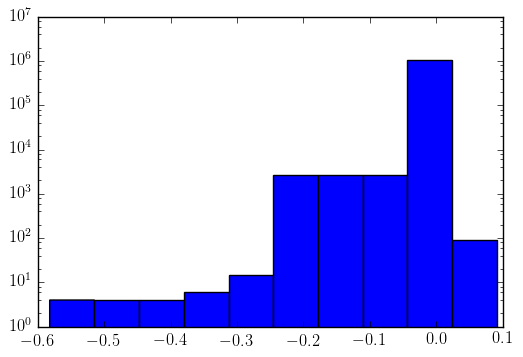

In [8]:
plt.hist(D.real.flatten(), log=True)

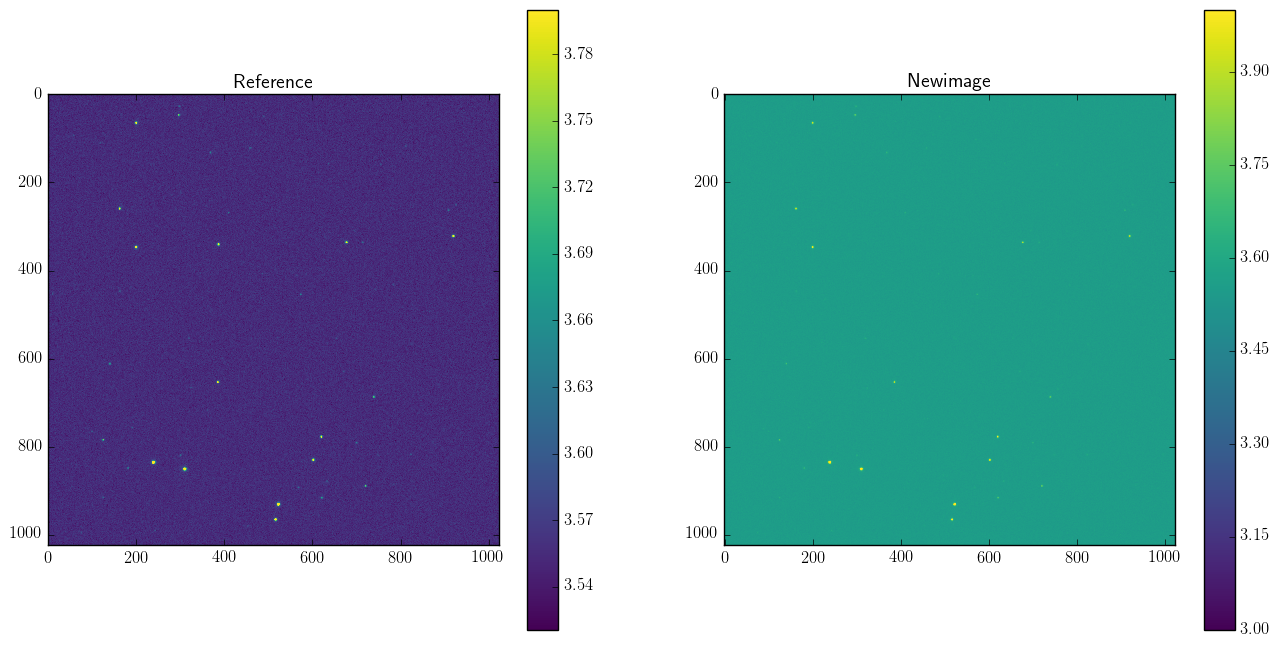

In [9]:
r = fits.getdata('testdiff_images/reference.fits')
n = fits.getdata('testdiff_images/aligned_newimage.fits')
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(np.log10(r), interpolation='none', cmap='viridis', vmax=3.8)
plt.colorbar()
plt.title('Reference')
plt.subplot(122)
plt.imshow(np.log10(n+1), interpolation='none', cmap='viridis', vmax=4., vmin=3.)
plt.colorbar()
plt.title('Newimage')

In [10]:
fits.writeto('testdiff_images/diff.fits', D.real, clobber=True)

## Check the alignement 

In [11]:
aan = fits.getdata('testdiff_images/aligned_newimage.fits')
n = fits.getdata('testdiff_images/newimage.fits')

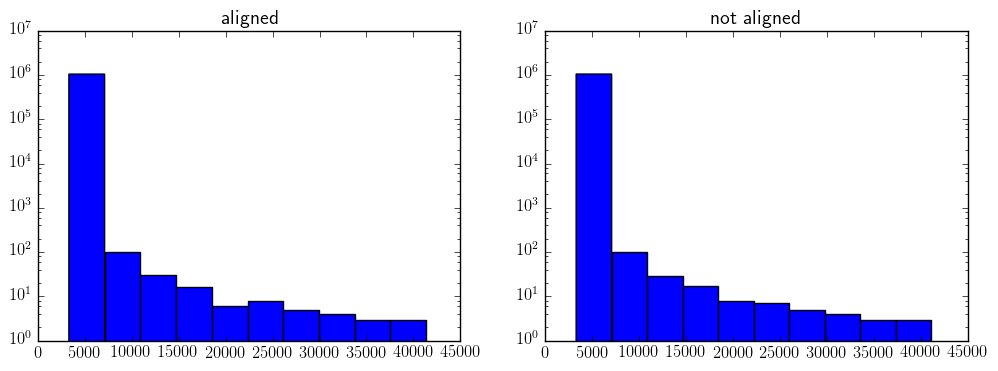

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(aan[aan>0.].flatten(), log=True)
plt.title('aligned')
plt.subplot(122)
plt.hist(n.flatten(), log=True)
plt.title('not aligned')

In [13]:
sum(aan.flatten()==0.)

2602

## VS ois image subtractor

In [14]:
import ois

In [15]:
ref = fits.getdata('testdiff_images/reference.fits')

In [17]:
%time d = ois.optimal_system(aan, ref)[0]

CPU times: user 49.3 s, sys: 608 ms, total: 49.9 s
Wall time: 49.1 s


In [18]:
fits.writeto('testdiff_images/diff_ois_default.fits', d, clobber=True)

(array([  3.00000000e+00,   8.00000000e+00,   1.30000000e+01,
          6.70000000e+01,   9.34000000e+02,   1.04697600e+06,
          5.60000000e+02,   8.00000000e+00,   2.00000000e+00,
          5.00000000e+00]),
 array([-8111.20652841, -6604.06394885, -5096.92136929, -3589.77878973,
        -2082.63621017,  -575.49363061,   931.64894896,  2438.79152852,
         3945.93410808,  5453.07668764,  6960.2192672 ]),
 <a list of 10 Patch objects>)

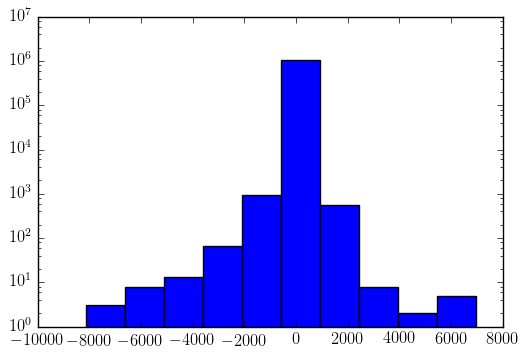

In [19]:
plt.hist(d.flatten(), log=True)

In [20]:
%time d = ois.optimal_system(aan, ref, method='AdaptiveBramich')[0]

CPU times: user 6min 1s, sys: 7.6 s, total: 6min 9s
Wall time: 8min 9s


In [21]:
fits.writeto('testdiff_images/diff_ois_ABramich.fits', d, clobber=True)

(array([  4.00000000e+00,   7.00000000e+00,   1.00000000e+00,
          1.31000000e+02,   5.78000000e+02,   1.04753700e+06,
          2.13000000e+02,   9.30000000e+01,   9.00000000e+00,
          3.00000000e+00]),
 array([-4766.49427379, -3869.46964089, -2972.445008  , -2075.4203751 ,
        -1178.3957422 ,  -281.37110931,   615.65352359,  1512.67815649,
         2409.70278938,  3306.72742228,  4203.75205518]),
 <a list of 10 Patch objects>)

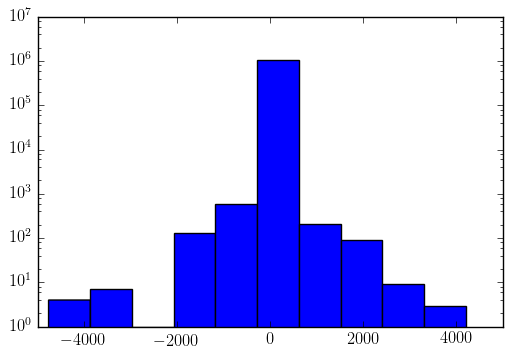

In [22]:
plt.hist(d.flatten(), log=True)